In [26]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import glob
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from IPython.display import display
from matplotlib import pyplot as plt

DIR_INPUT = '/home/arti/DL/Projects/Detection/[Det] Faster-RCN - Face Detection/Data'
DIR_VALID = f'{DIR_INPUT}/valid'
DIR_MODEL_SAVE = '/home/arti/DL/PyCharmPj/[Det] F-RCN on PKLot Dataset/models'
lable_path_valid = f'{DIR_INPUT}/valid/_annotations.txt'

In [2]:
def read_yolov4_format_as_df(lable_path):
    truth = {}
    f = open(lable_path, 'r', encoding='utf-8')
    for line in f.readlines():
        data = line.split(" ")
        truth[data[0]] = []
        for i in data[1:]:
            truth[data[0]].append([int(j) for j in i.split(',')])

    data = truth.items()
    data = np.array(list(data))
    df = pd.DataFrame(data)
    return df

In [3]:
valid_df = read_yolov4_format_as_df(lable_path_valid)
valid_df = valid_df.explode([1]).reset_index(drop=True)

In [4]:
valid_df.columns = ['image_id', 'bbox']

valid_df.bbox = valid_df.bbox.astype(str)

In [7]:
# drop not_existing values

names = glob.glob1(DIR_VALID, "*.jpg")
valid_df = valid_df.assign(exists=0)
valid_df.loc[valid_df.image_id.isin(names), 'exists'] = 1

valid_df = valid_df[valid_df.exists==1]
valid_df = valid_df.drop('exists', axis=1)

In [8]:
valid_df['x1'] = -1
valid_df['y1'] = -1
valid_df['x2'] = -1
valid_df['y2'] = -1
valid_df['cls'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1, -1]
    return r

valid_df[['x1', 'y1', 'x2', 'y2', 'cls']] = np.stack(valid_df['bbox'].apply(lambda x: expand_bbox(x)))
valid_df.drop(columns=['bbox'], inplace=True)
valid_df['x1'] = valid_df['x1'].astype(np.float)
valid_df['y1'] = valid_df['y1'].astype(np.float)
valid_df['x2'] = valid_df['x2'].astype(np.float)
valid_df['y2'] = valid_df['y2'].astype(np.float)
valid_df['cls'] = valid_df['cls'].astype(np.float)

In [10]:
valid_df.cls = 1
valid_df['width'] = 640
valid_df['height'] = 640

In [12]:
class PKLotDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x1', 'y1', 'x2', 'y2']].values
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [13]:
# Albumentations
def get_valid_transform():
    return A.Compose([
        A.Resize(height=256, width=256, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


# Create the model

In [28]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [30]:
num_classes = 2  # 1 class (car) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [31]:
model.load_state_dict(torch.load(DIR_MODEL_SAVE+'/fasterrcnn.pth'))

<All keys matched successfully>

In [32]:
def collate_fn(batch):
    return tuple(zip(*batch))

valid_dataset = PKLotDataset(valid_df, DIR_VALID, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(valid_dataset)).tolist()

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [33]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [34]:
model.to(device);

In [35]:
it = iter(valid_data_loader)
images, targets, image_ids = next(it)
images, targets, image_ids = next(it)

In [36]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [37]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [38]:
boxes = outputs[3]['boxes'].detach().cpu().numpy().astype(np.int32)
sample = images[3].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


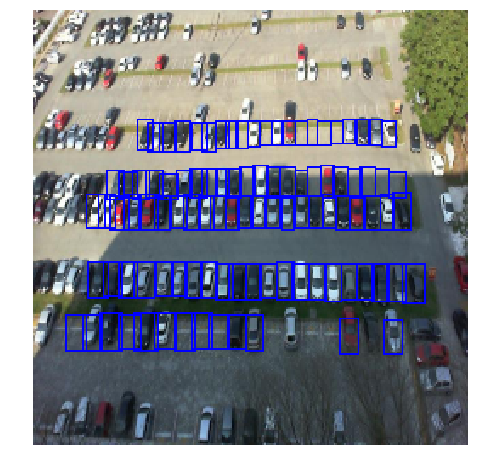

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (0, 0, 120), 1)
    
ax.set_axis_off()
ax.imshow(sample)

### Set threshold to 0.8

In [97]:
boxes = outputs[3]['boxes'].detach().cpu().numpy().astype(np.int32)
scores = outputs[3]['scores'].detach().cpu().numpy().astype(np.float)
indexes = np.where(scores > 0.6)[0]
boxes = boxes[indexes]    
sample = images[3].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


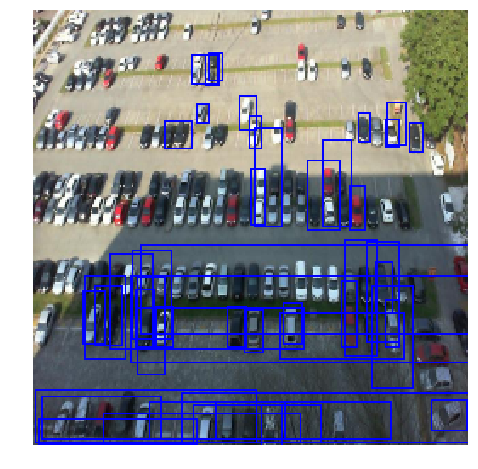

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (0, 0, 220), 1)
    
ax.set_axis_off()
ax.imshow(sample)

# Save

In [94]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')